In [4]:
import ipywidgets as widgets
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
import copy
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [1]:
def plot_candlestick(coin, start_date, final_date, base_date=0):
    temp_df = copy.deepcopy(df_checked[coin]).dropna()
    close_price = temp_df['price'].iloc[1:].values
    temp_df = temp_df[:-1]
    temp_df['close_price'] = close_price
    temp_df = temp_df[temp_df['snapped_at'] >= start_date]
    temp_df = temp_df[temp_df['snapped_at'] <= final_date]
    high_price = np.maximum(temp_df['price'], temp_df['close_price'])
    low_price = np.minimum(temp_df['price'], temp_df['close_price'])
    fig = go.Figure(data=[go.Candlestick(x=temp_df['snapped_at'],
                open=temp_df['price'],
                high=high_price,
                low=low_price,
                close=temp_df['close_price'])])
    if base_date != 0:
        fig.update_layout(title=coin,
            shapes = [dict(
            x0=base_date, x1=base_date, y0=0, y1=1, xref='x', yref='paper',
            line_width=2)])
    return fig

In [2]:
CUR_DIR = os.curdir
PATH_FILE = CUR_DIR + '/fileCSVNow/fileCSV - Copy/'

In [5]:
coin_list = os.listdir(PATH_FILE)
dict_checkbox = {}
sel_all = widgets.Checkbox(
    value=False,
    description='all',
    disabled=False,
    indent=False
)
for i in range(len(coin_list)):
    file_name = coin_list[i].split('-')
    coin_name = file_name[0]
    for j in file_name[1:-1]:
        # print(i)
        if j != 'usd':
            coin_name = coin_name + '-' + j
        else:
            break
    coin_list[i] = coin_name
    dict_checkbox[coin_name] = widgets.Checkbox(
                                value=False,
                                description=coin_name,
                                disabled=False,
                                indent=False,
                                continous_update=True
                            )
    widgets.dlink((sel_all, 'value'), (dict_checkbox[coin_name], 'value'))


DISP_COL = 20

dict_vbox = {}
for i in range(DISP_COL):
    dict_vbox[i] = []
dict_vbox[0].append(sel_all)

for i in range(1,len(coin_list)+1):
    coord = i%DISP_COL
    dict_vbox[coord].append(dict_checkbox[coin_list[i-1]])

hbox = [widgets.VBox(i) for i in dict_vbox.values()]
display(widgets.HBox(hbox))

In [6]:
list_checked = []
for i in coin_list:
    if dict_checkbox[i].value:
        list_checked.append(i)

df_checked = {}
for i in list_checked:
    df_checked[i] = pd.read_csv(PATH_FILE + i + '-usd-max.csv')
    df_checked[i]['pct_change'] = df_checked[i]['price'].pct_change()
    df_checked[i]['pct_change'] = np.where(df_checked[i]['pct_change'] > 10**3, 10, df_checked[i]['pct_change'])
    df_checked[i]['snapped_at'] = pd.to_datetime(df_checked[i]['snapped_at'], format='%Y-%m-%d %H:%M:%S UTC')


In [7]:
PUMP_THRESHOLD = 1
PUMP_THRESHOLD_INITIAL = 0.5
WINDOW_BEFORE = 7
WINDOW_AFTER = 30
PCT_THRESHOLD = 0.3

data_pump = []
for i in tqdm(list_checked):
# for i in ['shib']:
    max_idx = max(df_checked[i].index)
    df_checked_dropna = df_checked[i].dropna()
    j = list(df_checked_dropna.index)[0]
    while j < max_idx:
        try:
            is_pump = False
            low_bound = j
            up_bound = min([low_bound+WINDOW_AFTER, max_idx+1])
            df_temp_next = df_checked_dropna.loc[low_bound:up_bound]
            max_price = max(df_temp_next['price'])
            idx_max_price = list(df_temp_next.index)[df_temp_next['price'].argmax()]
            base_price = min(df_temp_next['price'])
            idx_base_price = list(df_temp_next.index)[df_temp_next['price'].argmin()]
            pct_to_max = (max_price - base_price)/base_price
            if  pct_to_max > PUMP_THRESHOLD_INITIAL:
                pump_analysis = True
            else:
                pump_analysis = False
                j = j+1
            while pump_analysis:
                low_bound = idx_max_price + 1
                up_bound = min([low_bound+WINDOW_AFTER, max_idx+1])
                df_temp_next = df_checked_dropna.loc[low_bound:up_bound]
                max_price_new = max(df_temp_next['price'])
                idx_max_price_new = list(df_temp_next.index)[df_temp_next['price'].argmax()]
                pct_to_max_new = (max_price_new - base_price)/base_price
                if pct_to_max_new > PUMP_THRESHOLD and max_price_new > max_price:
                    idx_max_price = idx_max_price_new
                    max_price = max_price_new
                    pct_to_max = pct_to_max_new
                    is_pump = True
                else:
                    pump_analysis = False
                    if is_pump:
                        data_pump.append([i, df_checked_dropna['snapped_at'].loc[idx_base_price], base_price, df_checked_dropna['snapped_at'].loc[idx_max_price], max_price, pct_to_max])
                    j = idx_max_price + 1
        except ValueError: j = j+1
        except Exception as e: 
            print(e)
            break
    # print(i)


 69%|██████▉   | 575/831 [01:49<00:28,  9.00it/s]

float division by zero


100%|██████████| 831/831 [02:47<00:00,  4.96it/s]


In [9]:
len(data_pump)

3144

In [19]:
df_checked_dropna.iloc[idx_base_price]['price']

5.70041420229866e-11

In [10]:
df_data_pump = pd.DataFrame(data_pump)
df_data_pump.columns = ['coin', 'base_date', 'base_price', 'max_date', 'max_price', 'pct_change']
df_data_pump.to_csv('small_pump.csv')
df_data_pump['base_date'] = pd.to_datetime(df_data_pump['base_date'], format='%Y-%m-%d %H:%M:%S UTC')
df_data_pump['max_date'] = pd.to_datetime(df_data_pump['max_date'], format='%Y-%m-%d %H:%M:%S UTC')
df_data_pump['pump_length'] = df_data_pump['max_date'] - df_data_pump['base_date']

arr_listing = []
for i in df_data_pump['coin']:
    date_listing = df_checked[i]['snapped_at'][0]
    arr_listing.append(date_listing)
df_data_pump['date_listing'] = arr_listing

df_data_pump['pump_to_listing'] = df_data_pump['base_date'] - df_data_pump['date_listing']


In [12]:
df_data_pump_30 = df_data_pump[df_data_pump['pump_length'] <= pd.Timedelta(30, 'd')]
print(len(df_data_pump_30[df_data_pump_30['pct_change'] >= 5]))
df_data_pump_30[df_data_pump_30['coin'] == 'shib']

127


,coin,base_date,base_price,max_date,max_price,pct_change,pump_length,date_listing,pump_to_listing
525,shib,2020-08-28,8.238667e-11,2020-09-04,5.428842e-10,5.589467,7 days,2020-08-01,27 days


In [21]:
LISTING_THRESHOLD = 100
df_data_pump_30_no_listing = df_data_pump_30[df_data_pump_30['pump_to_listing'] > pd.Timedelta(LISTING_THRESHOLD,'d')]
df_data_pump_30_no_listing.head(100)

,coin,base_date,base_price,max_date,max_price,pct_change,pump_length,date_listing,pump_to_listing
0,10set,2022-06-09,0.276610,2022-06-25,3.752881,12.567406,16 days,2021-04-02,433 days
3,ach,2021-07-21,0.001368,2021-08-07,0.159230,115.397746,17 days,2020-09-08,316 days
10,agix,2021-05-29,0.037961,2021-06-09,0.804910,20.203556,11 days,2018-01-22,1223 days
16,alu,2021-10-13,0.037773,2021-11-03,0.426552,10.292616,21 days,2021-04-30,166 days
19,amp,2021-01-28,0.005664,2021-02-14,0.036486,5.442166,17 days,2020-09-09,141 days
...,...,...,...,...,...,...,...,...,...
656,xki,2021-11-09,0.033357,2021-11-27,0.487947,13.628216,18 days,2021-05-21,172 days
664,xpr,2021-09-22,0.006046,2021-10-20,0.047137,6.796220,28 days,2020-04-07,533 days
671,xvg,2015-02-06,0.000002,2015-02-19,0.000033,13.866493,13 days,2014-10-25,104 days
681,zig,2021-11-22,0.020934,2021-12-01,0.177940,7.500013,9 days,2021-04-15,221 days


In [30]:
df_data_pump_30_no_listing['base_date']

0     2022-06-09
3     2021-07-21
10    2021-05-29
16    2021-10-13
19    2021-01-28
         ...    
656   2021-11-09
664   2021-09-22
671   2015-02-06
681   2021-11-22
685   2019-08-24
Name: base_date, Length: 100, dtype: datetime64[ns]

In [26]:
df_data_pump_30_no_listing.to_csv('pump_lessthan30.csv')

In [25]:
idx = 664
days_before = 60
days_after = 20
fig = plot_candlestick(df_data_pump_30_no_listing['coin'][idx],df_data_pump_30_no_listing['base_date'][idx] - pd.Timedelta(days_before, 'd'), 
                        df_data_pump_30_no_listing['base_date'][idx]+pd.Timedelta(days_after, 'd'), base_date=df_data_pump_30_no_listing['base_date'][idx])
# fig.update_layout(shapes = [dict(
#         x0=df_data_pump_steady['base_date'][idx], x1=df_data_pump_steady['base_date'][idx], y0=0, y1=1, xref='x', yref='paper',
#         line_width=2)])
fig

In [22]:
import plotly.express as px
fig = px.histogram(df_data_pump, x="pump_length")
fig.show()

fig = go.Figure(data=[go.Histogram(x=arr_early_max_price[arr_early_max_price <= 0])])
fig.show()

In [12]:
THRESHOLD_STEADY = 60
df_data_pump_steady = df_data_pump[df_data_pump['base_date'] - df_data_pump['date_listing'] >= pd.Timedelta(THRESHOLD_STEADY, 'd')]
df_data_pump_steady.reset_index(inplace=True)

In [ ]:
PUMP_THRESHOLD = 10
df_data_pump_steady = df_data_pump_steady[df_data_pump_steady['pct_change'] > PUMP_THRESHOLD].reset_index()

In [ ]:
idx = 100
days_before = 60
days_after = 5
fig = plot_candlestick(df_data_pump_steady['coin'][idx],df_data_pump_steady['base_date'][idx] - pd.Timedelta(days_before, 'd'), 
                        df_data_pump_steady['base_date'][idx]+pd.Timedelta(days_after, 'd'), base_date=df_data_pump_steady['base_date'][idx])
# fig.update_layout(shapes = [dict(
#         x0=df_data_pump_steady['base_date'][idx], x1=df_data_pump_steady['base_date'][idx], y0=0, y1=1, xref='x', yref='paper',
#         line_width=2)])
fig

In [ ]:
idx = 154
days_before = 100
days_after = 60
fig = plot_candlestick(df_data_pump_steady['coin'][idx],df_data_pump_steady['base_date'][idx] - pd.Timedelta(days_before, 'd'), 
                        df_data_pump_steady['base_date'][idx]+pd.Timedelta(days_after, 'd'), base_date=df_data_pump_steady['base_date'][idx])
fig

In [ ]:
idx = 720
days_before = 100
days_after = 5
fig = plot_candlestick(df_data_pump_steady['coin'][idx],df_data_pump_steady['base_date'][idx] - pd.Timedelta(days_before, 'd'), 
                        df_data_pump_steady['base_date'][idx]+pd.Timedelta(days_after, 'd'), base_date=df_data_pump_steady['base_date'][idx])
fig

In [30]:
listing_to_pump = []
for i in df_data_pump_30['coin'].unique():
    temp_df= df_data_pump_30[df_data_pump_30['coin'] == i]
    listing_to_pump.append((temp_df['base_date'].iloc[0] - temp_df['date_listing'].iloc[0]).days)
    
fig = go.Figure(data=[go.Histogram(x=listing_to_pump)])
fig.show()
print('Banyaknya data coin yg dipump ', len(listing_to_pump))

Banyaknya data coin yg dipump  96


In [14]:
import plotly.express as px
fig = px.histogram(df_data_pump_30, x="coin")
fig.show()

In [ ]:
df_data_pump_steady[df_data_pump_steady['pct_change'] >= 10]

,index,coin,base_date,base_price,max_date,max_price,pct_change,pump_length,date_listing
0,0,10set,2022-06-09,0.276610,2022-06-25,3.752881,12.567406,16 days,2021-04-02
2,3,ach,2021-07-21,0.001368,2021-08-07,0.159230,115.397746,17 days,2020-09-08
3,6,ads,2019-03-25,0.013898,2019-06-03,0.865757,61.294233,70 days,2017-10-29
4,7,ads,2021-03-05,0.035086,2021-05-15,0.524421,13.946808,71 days,2017-10-29
6,10,agix,2021-05-29,0.037961,2021-06-09,0.804910,20.203556,11 days,2018-01-22
...,...,...,...,...,...,...,...,...,...
527,673,xvg,2017-03-20,0.000010,2017-06-06,0.006659,641.731018,78 days,2014-10-25
528,674,xvg,2017-11-23,0.005429,2017-12-24,0.261874,47.239292,31 days,2014-10-25
529,675,xvs,2020-12-30,3.286471,2021-02-20,94.573640,27.776651,52 days,2020-10-06
530,676,xyo,2021-01-30,0.000210,2021-04-05,0.007910,36.650722,65 days,2018-06-12


# Initial Coin Offering Analysis

In [15]:
NUM_EARLY_DAY = 100
arr_early_max_price = []
for i in df_checked.keys():
    temp_df = df_checked[i].iloc[:NUM_EARLY_DAY]
    max_price = max(temp_df['price'])
    pct_to_max = (max_price - temp_df['price'][0])/temp_df['price'][0]
    if pct_to_max == 0:
        min_price = min(temp_df['price'])
        pct_to_min = (min_price - temp_df['price'][0])/temp_df['price'][0]
        arr_early_max_price.append(pct_to_min)
    else:
        arr_early_max_price.append(pct_to_max)
arr_early_max_price = np.array(arr_early_max_price)
fig = go.Figure(data=[go.Histogram(x=arr_early_max_price[np.logical_and((arr_early_max_price > 0),(arr_early_max_price < 10))])])
fig.show()

fig = go.Figure(data=[go.Histogram(x=arr_early_max_price[arr_early_max_price <= 0])])
fig.show()

In [16]:
print('probability coin down to > 30%: ', len(arr_early_max_price[arr_early_max_price <= -0.3])/len(arr_early_max_price))
print('probability coin up to > 100%: ', len(arr_early_max_price[arr_early_max_price >= 1])/len(arr_early_max_price))
print('probability coin up to > 200%: ', len(arr_early_max_price[arr_early_max_price >= 2])/len(arr_early_max_price))
print('probability coin up to > 800%: ', len(arr_early_max_price[arr_early_max_price >= 8])/len(arr_early_max_price))

probability coin down to > 30%:  0.14007308160779536
probability coin up to > 100%:  0.46772228989037756
probability coin up to > 200%:  0.32399512789281365
probability coin up to > 800%:  0.12423873325213154


# Steady Coin Analysis

In [ ]:
WINDOW_BEFORE = 30
arr_pct_change = []
for i in df_data_pump_steady.index:
    coin = df_data_pump_steady['coin'][i]
    temp_df = df_checked[coin]
    base_date = df_data_pump_steady['base_date'][i]
    listing_date = df_data_pump_steady['date_listing'][i]
    temp_df = temp_df[temp_df['snapped_at'] > base_date-pd.Timedelta(WINDOW_BEFORE, 'd')]
    temp_df = temp_df[temp_df['snapped_at'] <= base_date]
    if len(temp_df) == WINDOW_BEFORE:
        arr_pct_change.append(temp_df['pct_change'].values.tolist())

In [ ]:
df_data_pump_steady.iloc[26]

level_0                          45
index                            56
coin                         avinoc
base_date       2019-09-03 00:00:00
base_price              3.01404e-05
max_date        2019-09-28 00:00:00
max_price                 0.0018999
pct_change                  62.0352
pump_length        25 days 00:00:00
date_listing    2018-08-10 00:00:00
Name: 26, dtype: object

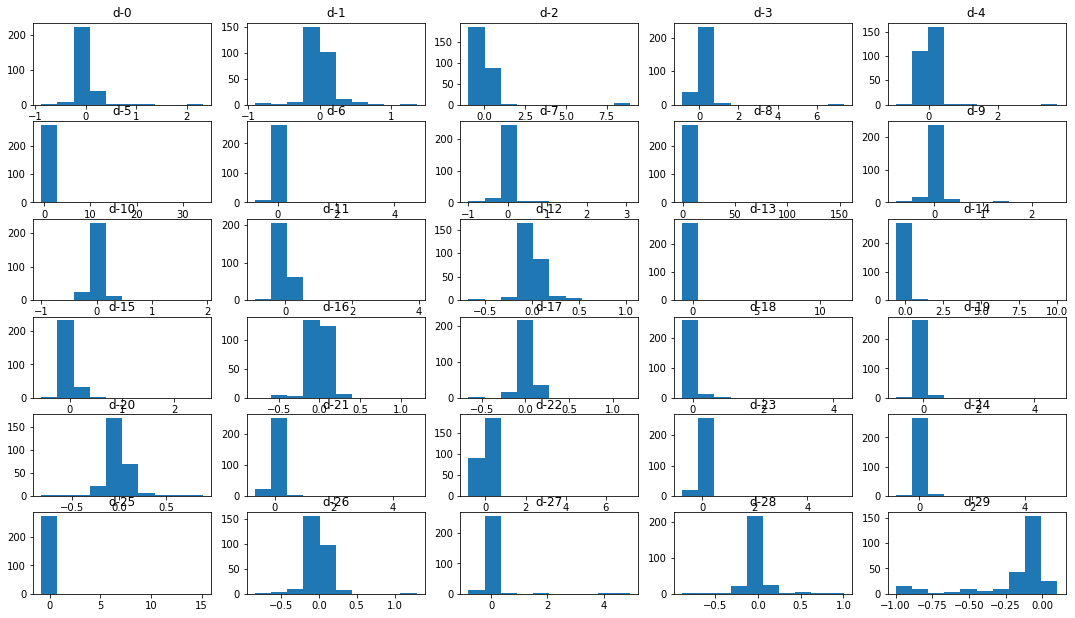

In [ ]:
n_x = 6
n_y = 5
fig, axs = plt.subplots(n_x, n_y)
for i in range(len(arr_pct_change[0])):
    x_ax = int(i/n_y)
    y_ax = i%n_y
    axs[x_ax, y_ax].hist([arr_pct_change[j][i] for j in range(len(arr_pct_change))])
    axs[x_ax, y_ax].set_title('d-%i' %i)

fig.set_size_inches(18.5, 10.5)


In [ ]:
[arr_pct_change[j][i] for j in range(len(arr_pct_change))]

IndexError: list index out of range

In [ ]:
a = []
for j in range(len(arr_pct_change)):
    # a.append(arr_pct_change[j][i])
    if len(arr_pct_change[j]) != 30:
        print(j)

26
27
28
47
51
70
78
136
189
210
226
232
251
267
284


In [ ]:
i

9

In [ ]:
arr_pct_change[j]

[-0.9849227072387,
 0.0,
 298.3720292632238,
 0.0,
 0.985288675049774,
 0.0054527193081586045,
 -0.9958141384934694,
 0.0,
 -0.006313539289696135]

In [27]:
df = pd.read_csv('pump_lessthan30.csv')

In [29]:
df['base_date']

0     2022-06-09
1     2021-07-21
2     2021-05-29
3     2021-10-13
4     2021-01-28
         ...    
95    2021-11-09
96    2021-09-22
97    2015-02-06
98    2021-11-22
99    2019-08-24
Name: base_date, Length: 100, dtype: object